# Crater attributes
Prototype analysis for a single detected crater. Extract crater attributes like best-fitting ellipse, eccentricity, gradient, etc.

In [1]:
import warnings
from pathlib import Path

import numpy as np
import rasterio
from skimage.measure import EllipseModel, regionprops, label, find_contours, approximate_polygon

# Get path to test images
images_dir = Path.cwd().parent.parent / 'test/fixtures'

# Construct filenames to grayscale image and individual crater annotations
img_ctx_fpath = images_dir / 'img1.png'
img_annot_fpaths = [images_dir / f'img1_annot{num}.png' for num in range(3)]
grad_image_fpath = images_dir / 'diagonal_gradient.png'

In [2]:
orig_image = rasterio.open(img_ctx_fpath).read().squeeze()
annot_images = [rasterio.open(img_annot_fpath).read().squeeze() 
                for img_annot_fpath in img_annot_fpaths]
grad_image = rasterio.open(img_ctx_fpath).read().squeeze()

label_objects = [label(annot_image) for annot_image in annot_images]
props = [regionprops(label_object) for label_object in label_objects]

/Users/wronk/.virtualenvs/mars/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [15]:
def calculate_crater_props(binary_label_img):
    
    if binary_label_img.ndim != 2:
        raise RuntimeError('Image must be 2d for calculating region properties.')
    
    props = regionprops(binary_label_img)

    print(f'Area = {props[0]["area"]}')
    print(f'Major Axis = {props[0]["major_axis_length"]}')
    print(f'Minor Axis = {props[0]["minor_axis_length"]}')
    print(f'Eccentricity = {props[0]["eccentricity"]}')
    print(f'Orientation = {props[0]["orientation"]}')

    # Spatial moments?
    # Euler number?
    
    # TODO: If we use EllipseModel, need to grab only the edge pixels (and not use filled blob)
    coords = np.stack(np.nonzero(binary_label_img), axis=1)
    em = EllipseModel()
    em.estimate(coords)
    print(f'Ellipse model params: {em.params}')
    
    
def calculate_grad(image, good_inds):
    """Calculate the X and Y gradient for an image using numpy's gradient.
    
    Parameters
    ==========
    image: array-like
        Image pixels.
    good_inds: array-like
        Bool mask for pixels to include when returninng mean gradient. 
        For example, pass the binary crater mask to only calculate the 
        gradient for pixels within the crater.
    
    Returns
    =======
    mean_h: float
        Mean horizontal gradient of pixels specified by `good_inds`. Positive
        is to the right.
    mean_v: float
        Mean vertical gradient of pixels specified by `good_inds`. Positive is
        downward.
    """
    # TODO: could improve function to take a list of good_inds and avoid
    # recomputing gradient repeatedly
    
    if good_inds.dtype != bool:
        raise ValueError('`good_inds` must be of type bool')
        
    np_mask = np.invert(good_inds) # Pixels we want to exclude should be True
    
    mean_h = np.ma.masked_array(np.gradient(image, axis=0),
                                mask=np_mask).mean()
    mean_v = np.ma.masked_array(np.gradient(image, axis=1),
                                mask=np_mask).mean()

    print(f'Grad horizontal:{mean_h}, Grad vertical:{mean_v}')
    return mean_h, mean_v


def calculate_wkt_border(binary_label_img, contour_tol=2.5, pad=1):
    """Pull out the polygon representation of the crater border."""
    
    # TODO: apply and remove padding properly; add test
    print(f'orig shape: {binary_label_img.shape}')
    padded_image = np.pad(binary_label_img, pad_width=1, mode='constant')
    print(f'padded shape: {padded_image.shape}')

    contours = find_contours(padded_image, 0.5)
    if len(contours) > 1:
        warnings.warn(f'Found {len(contours)} contour objects. Expected 1.')
    
    coords = approximate_polygon(contours[0], tolerance=contour_tol)
    closed = coords[0] == coords[-1]
    
    return coords, closed
    

In [16]:
# Get some values from first crater
for li, binary_label_img in enumerate(label_objects):
    print (f'\nObject {li}')
    calculate_crater_props(binary_label_img)
    calculate_grad(orig_image, binary_label_img.astype(np.bool))


Object 0
Area = 365
Major Axis = 21.55794993684353
Minor Axis = 21.55794993684353
Eccentricity = 0.0
Orientation = 0.7853981633974483
Ellipse model params: [236.99999999996908, 44.00000000000697, 7.621885183733106, 7.621887402948319, 1.6470532156733175]
Grad horizontal:0.8780821917808219, Grad vertical:-0.33013698630136984

Object 1
Area = 8166
Major Axis = 143.50196551711082
Minor Axis = 76.42045121336285
Eccentricity = 0.8464052120638251
Orientation = 0.0
Ellipse model params: [174.4999999980865, 225.55693613864304, 27.124554096602242, 50.587078011778424, 1.5707963269431249]
Grad horizontal:0.37447954935096744, Grad vertical:0.6970977222630419

Object 2
Area = 1129
Major Axis = 50.04730585494444
Minor Axis = 28.76355266027332
Eccentricity = 0.818344999167847
Orientation = -0.514135377558573
Ellipse model params: [47.15534054087704, 21.710982033865484, 10.175457518522418, 17.68397594416444, 1.0568183030693015]
Grad horizontal:-0.9694419840566874, Grad vertical:-1.8556244464127547


orig shape: (256, 256)
padded shape: (258, 258)
orig shape: (256, 256)
padded shape: (258, 258)
[[246.99803922 256.        ]
 [243.99803922 232.        ]
 [229.99803922 208.        ]
 [210.         192.00196078]
 [186.         184.00196078]
 [160.         185.00196078]
 [133.         197.00196078]
 [113.00196078 219.        ]
 [104.00196078 244.        ]
 [105.         256.99803922]
 [246.99803922 256.        ]]
orig shape: (256, 256)
padded shape: (258, 258)


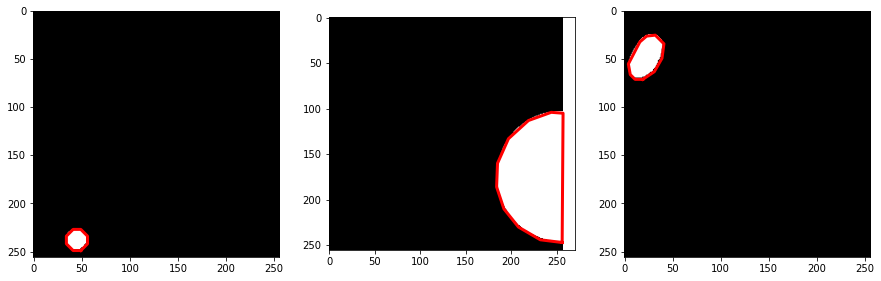

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, figsize=(15, 7))
plt.gray()

for ii, ax in enumerate(axes):
    ax.imshow(annot_images[ii])
    contour, closed = calculate_wkt_border(annot_images[ii])
    
    ax.plot(contour[:, 1], contour[:, 0], '-r', linewidth=3)
    if ii == 1:
        print(contour)
